In [1]:
import sys
sys.path.insert(1, "../utils")

from utils_general import *
from PC_new import *
from CGM_dynamic import *


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [4]:
(3/8) * (1 + 3/np.sqrt(2*np.log(2)))**(-1)

0.10569437906826093

# 1. Two-Dimensional Dataset, with brute-force PC:

In [9]:
begin_time = time.time()

alpha = 0.7
beta = 0.6
theta = np.pi/6
A = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) * alpha
B = np.array([[1], [1]]) * beta
T = 10
num_traj = 5000

# B @ u_vec[0]
# u_vec

for traj_id in range(num_traj):
    x_0 = np.random.randn()
    x_vec = np.zeros((2, T))
    x_vec[:, 0] = x_0
    u_vec = np.random.randn(1,T)
    w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] + w_vec[:, t]
    
    x_u_vec = np.block([x_vec.T, u_vec.reshape((T, 1))])
    x_u_vec = np.block([x_u_vec[:-1, :], x_u_vec[1:, :]])
    
    if traj_id == 0:
        traj_dataset = x_u_vec
    else:
        traj_dataset = np.block([[traj_dataset], [x_u_vec]])
    
# print(A.shape)
# print(x_vec[:, 0].shape)
# x_vec

end_time = time.time()

print("Time:", end_time - begin_time)


Time: 2.1450886726379395


In [10]:
traj_dataset.shape

(45000, 6)

  0%|          | 0/6 [00:00<?, ?it/s]

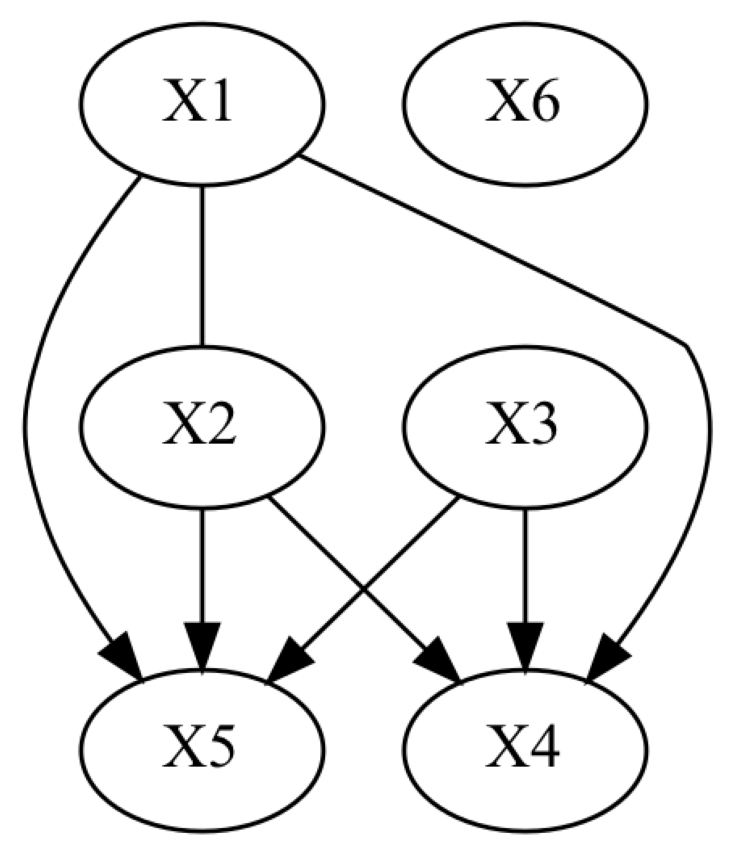

Green: undirected; Blue: directed; Red: bi-directed



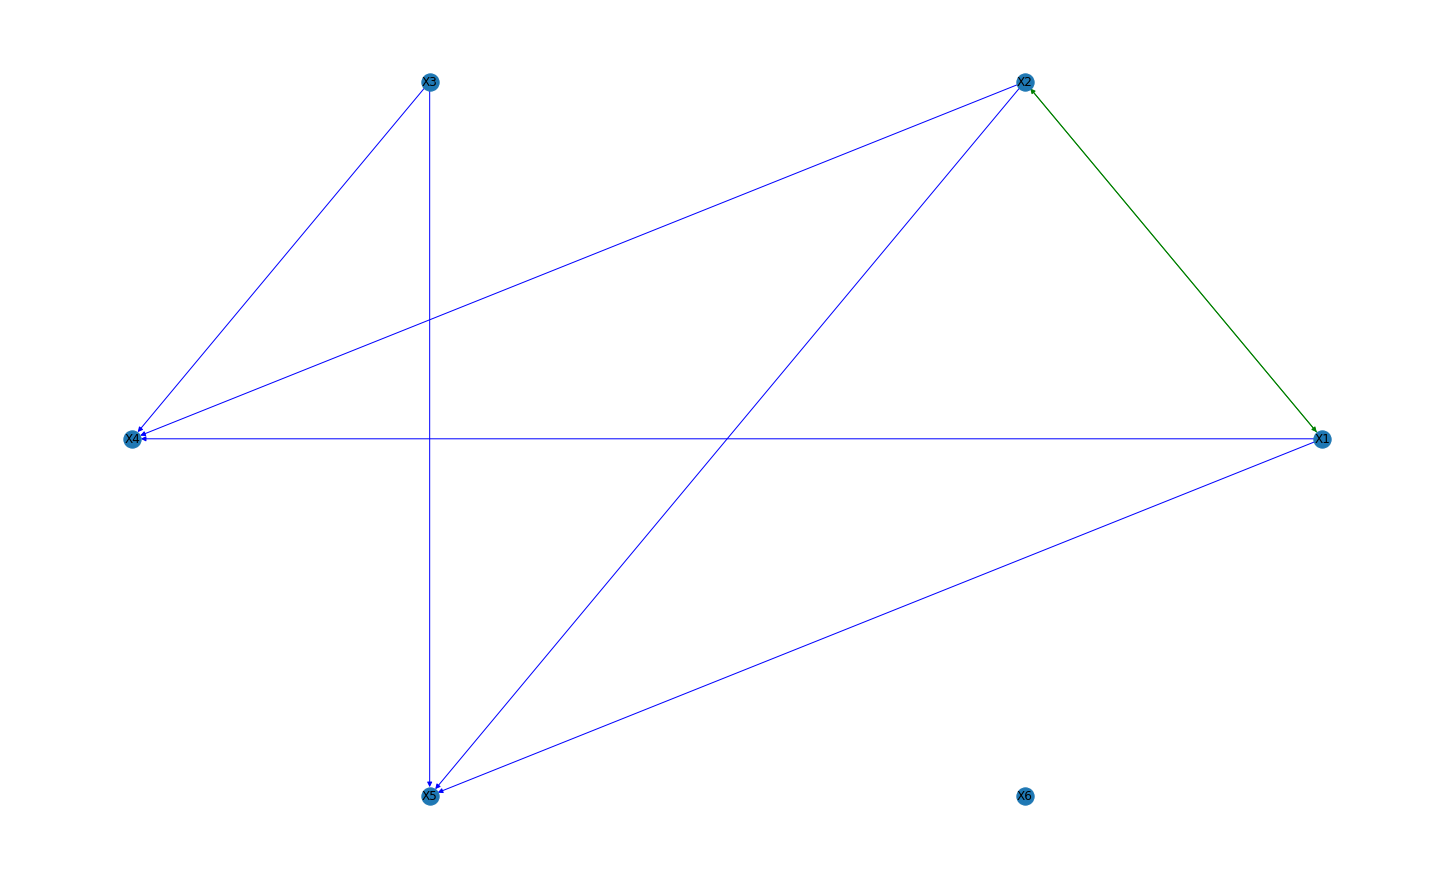

In [11]:
traj_dataset_trunc = traj_dataset

# # Run PC and obtain the estimated graph (CausalGraph object)
# cg = pc(traj_dataset_trunc, 0.05, fisherz, verbose=True)  
cg = pc(traj_dataset_trunc, 0.05, fisherz)

# visualization using pydot
cg.draw_pydot_graph()

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)


# 2. n-Dimensional Dataset:

In [5]:
def gram_schmidt_normalized(A):
    assert A.shape[0] == A.shape[1]
    B = np.zeros(A.shape)
    B[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0])
    for k in np.arange(1, A.shape[1]):
#         print("\n", k, ":")
        temp_vec = np.zeros(A.shape[0])
        for j in range(k):
#             print(j)
            temp_vec += (A[:, k].T @ B[:, j]) * B[:, j]
        B_vec_unnormalized = A[:, k] - temp_vec
        B[:, k] = B_vec_unnormalized / np.linalg.norm(B_vec_unnormalized)
    
    assert np.linalg.det(B) != 0
    
    if np.linalg.det(B) < 0:
        B[:, 0] *= -1
    
    return B

def hat(v):
    assert v.shape == (3,) or v.shape == (3, 1)
    return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

def rodrigues(v, theta):
    assert v.shape == (3,) or v.shape == (3, 1)
    v_hat = hat(v)
    return np.identity(3) + np.sin(theta) * v_hat + (1 - np.cos(theta)) * (v_hat @ v_hat)

# (a) brute-force PC:

In [32]:
begin_time = time.time()

alpha = 0.7
beta = 0.6
dim = 3

A = gram_schmidt_normalized(np.random.rand(dim, dim)) * alpha
# v_rot = np.rand(dim, 1)
# theta = np.pi/6
# A = sp.linalg.expm(A)

B = np.ones((dim, 1)) * beta
T = 3
num_traj = 100000

# B @ u_vec[0]
# u_vec

for traj_id in range(num_traj):
    x_0 = np.random.randn()
    x_vec = np.zeros((dim, T))
    x_vec[:, 0] = x_0
    u_vec = np.random.randn(1, T)
    w_vec = np.random.randn(dim, T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] + w_vec[:, t]
    
    x_u_vec = np.block([x_vec.T, u_vec.reshape((T, 1))])
    x_u_vec = np.block([x_u_vec[:-1, :], x_u_vec[1:, :]])
    
    if traj_id == 0:
        traj_dataset = x_u_vec
    else:
        traj_dataset = np.block([[traj_dataset], [x_u_vec]])


# print(A.shape)
# print(x_vec[:, 0].shape)
# x_vec

end_time = time.time()

print("Time:", end_time - begin_time)

Time: 169.54185795783997


In [33]:
traj_dataset.shape

(200000, 8)

  0%|          | 0/8 [00:00<?, ?it/s]

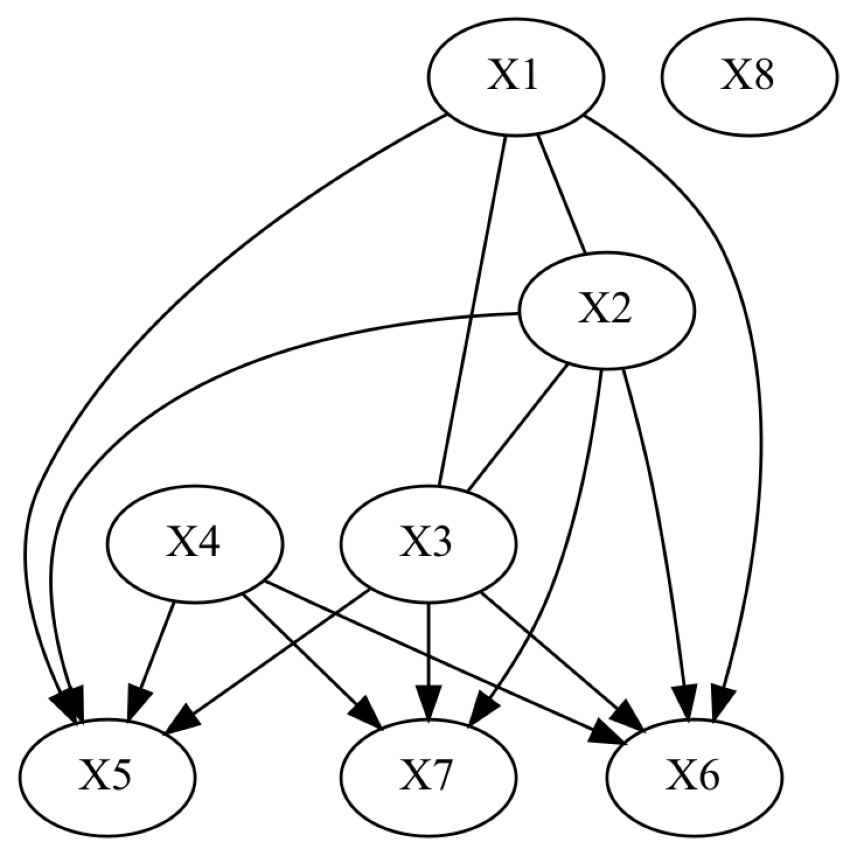

Green: undirected; Blue: directed; Red: bi-directed



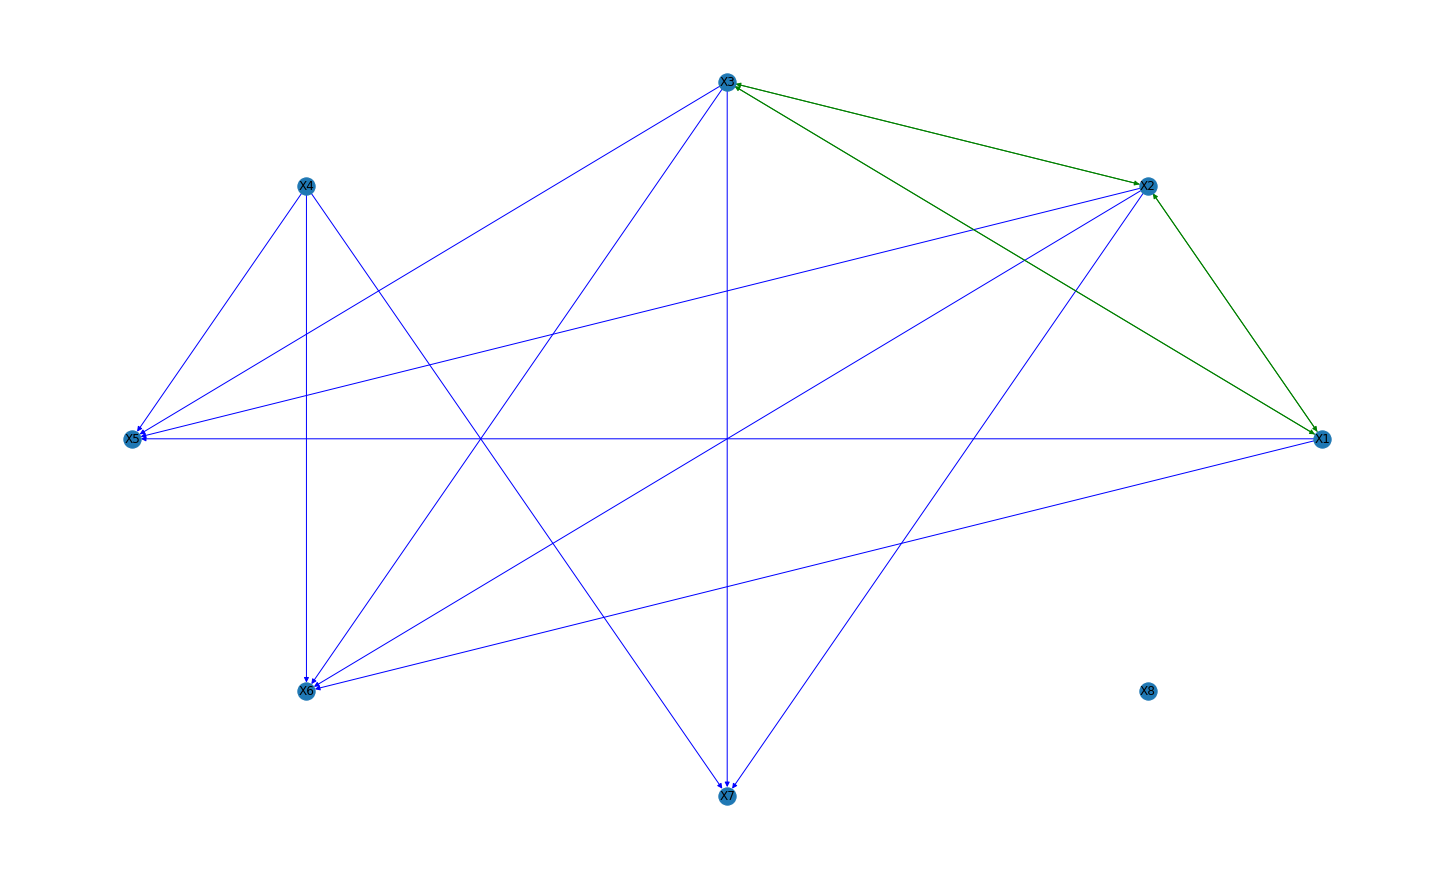

In [34]:
traj_dataset_trunc = traj_dataset

# # Run PC and obtain the estimated graph (CausalGraph object)
cg = pc(traj_dataset_trunc, 0.05, fisherz) 
# cg = pc(traj_dataset_trunc, 0.3, fisherz)

# visualization using pydot
cg.draw_pydot_graph()

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [35]:
# Save dataset:

path_directory = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"

path_file = path_directory + "system_n_dim_brute_force_pc.csv"
traj_dataset_pd = pd.DataFrame(traj_dataset)
traj_dataset_pd.to_csv(path_file, index=False)

# (b) With background knowledge:

In [67]:
begin_time = time.time()

alpha = 0.7
beta = 0.6
dim = 3

A = gram_schmidt_normalized(np.random.rand(dim, dim)) * alpha
# v_rot = np.rand(dim, 1)
# theta = np.pi/6
# A = sp.linalg.expm(A)

B = np.ones((dim, 1)) * beta
T = 3
num_traj = 40000

# B @ u_vec[0]
# u_vec

for traj_id in range(num_traj):
    x_0 = np.random.randn()
    x_vec = np.zeros((dim, T))
    x_vec[:, 0] = x_0
    u_vec = np.random.randn(1, T)
    w_vec = np.random.randn(dim, T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] + w_vec[:, t]
    
    x_u_vec = np.block([x_vec.T, u_vec.reshape((T, 1))])
    x_u_vec = np.block([x_u_vec[:-1, :], x_u_vec[1:, :]])
    
    if traj_id == 0:
        traj_dataset = x_u_vec
    else:
        traj_dataset = np.block([[traj_dataset], [x_u_vec]])


# print(A.shape)
# print(x_vec[:, 0].shape)
# x_vec

end_time = time.time()

print("Time:", end_time - begin_time)

Time: 20.607069969177246


In [68]:
# num_nodes_per_tier = dim
traj_dataset.shape

(80000, 8)

In [118]:
def pc_time_series_1(data: np.ndarray, num_nodes_per_tier: int, alpha: float, indep_test, \
                     stable: bool = True, uc_rule: int = 1, uc_priority: int = -1, \
                     background_knowledge: BackgroundKnowledge = None, \
                     verbose: bool = False, show_progress: bool = True) -> CausalGraph:
    
    # (1) Run skeleton search over specific pairs of nodes.
    indep_test = CIT(data, indep_test)
    cg_1 = SkeletonDiscovery.skeleton_discovery(data, alpha, indep_test, background_knowledge=background_knowledge, verbose=verbose, show_progress=show_progress)

    # (2) Apply v-structure and R_1, ..., R_4 rules to nodes in E_{t, t+1}, E_{t+1}.
    if uc_rule == 0:
        if uc_priority != -1:
            cg_2 = UCSepset.uc_sepset(cg_1, uc_priority, background_knowledge=None)
        else:
            cg_2 = UCSepset.uc_sepset(cg_1, background_knowledge=None)
        cg_2 = Meek.meek(cg_2, background_knowledge=None)

    elif uc_rule == 1:
        if uc_priority != -1:
            cg_2 = UCSepset.maxp(cg_1, uc_priority, background_knowledge=None)
        else:
            cg_2 = UCSepset.maxp(cg_1, background_knowledge=None)
        cg_2 = Meek.meek(cg_2, background_knowledge=None)

    elif uc_rule == 2:
        if uc_priority != -1:
            cg_2 = UCSepset.definite_maxp(cg_1, alpha, uc_priority, background_knowledge=None)
        else:
            cg_2 = UCSepset.definite_maxp(cg_1, alpha, background_knowledge=None)
        cg_before = Meek.definite_meek(cg_2, background_knowledge=None)
        cg_2 = Meek.meek(cg_before, background_knowledge=None)
    else:
        raise ValueError("uc_rule should be in [0, 1, 2]")
    
    # (3) Apply temporal constraints to E_{t, t+1}.
    cg_3 = deepcopy(cg_2)
    for (x, y) in itertools.product(np.arange(num_nodes_per_tier), repeat=2):
        if cg_3.G.graph[x, y + num_nodes_per_tier] != 0:
            cg_3.G.remove_edge(cg_3.G.get_edge(cg_3.G.nodes[x], cg_3.G.nodes[y + num_nodes_per_tier]))
            cg_3.G.add_edge(Edge(cg_3.G.nodes[x], cg_3.G.nodes[y + num_nodes_per_tier], Endpoint.TAIL, Endpoint.ARROW))
    
    # (4) Remove directed edges among edges in the same tier, replace with undirected edges:
    cg_4 = deepcopy(cg_3)
    for (x, y) in itertools.product(np.arange(num_nodes_per_tier), repeat=2):
        if x != y:
            if cg_4.G.graph[x, y] != 0:
                print(x, y)
                cg_4.G.remove_edge(cg_4.G.get_edge(cg_4.G.nodes[x], cg_4.G.nodes[y]))
                cg_4.G.add_edge(Edge(cg_4.G.nodes[x], cg_4.G.nodes[y], Endpoint.TAIL, Endpoint.TAIL))
            if cg_4.G.graph[x + num_nodes_per_tier, y + num_nodes_per_tier] != 0:
                print(x, y)
                cg_4.G.remove_edge(cg_4.G.get_edge(cg_4.G.nodes[x], cg_4.G.nodes[y]))
                cg_4.G.add_edge(Edge(cg_4.G.nodes[x], cg_4.G.nodes[y], Endpoint.TAIL, Endpoint.TAIL))
    
    return cg_3, cg_4
#     return cg_4



4


  0%|          | 0/8 [00:00<?, ?it/s]

0 1
0 2
1 0
1 2
2 0
2 1


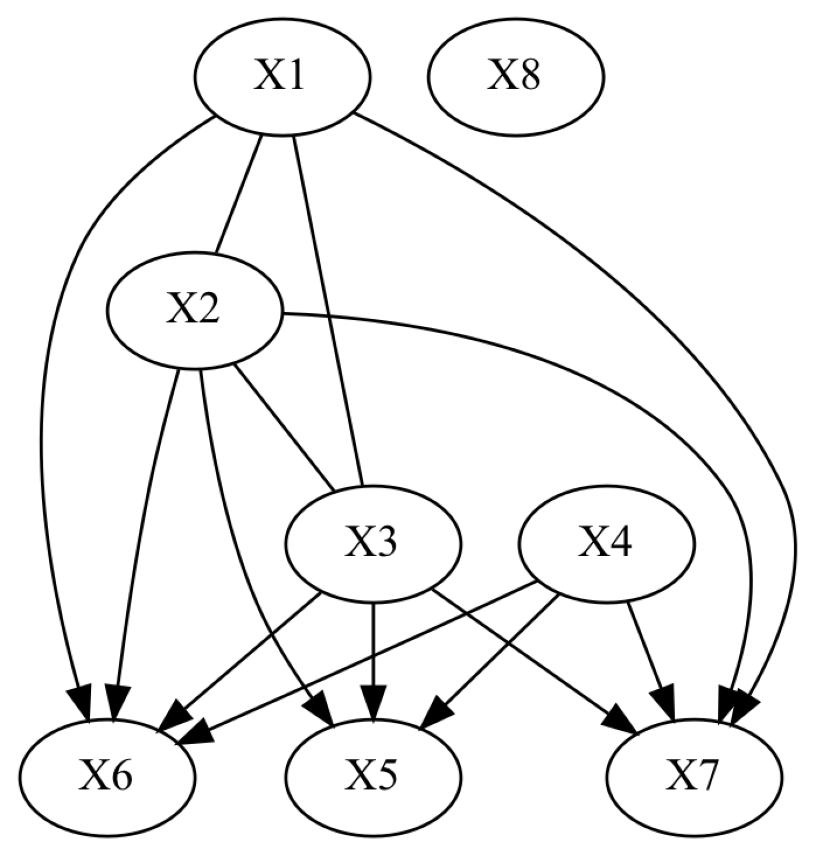

Green: undirected; Blue: directed; Red: bi-directed



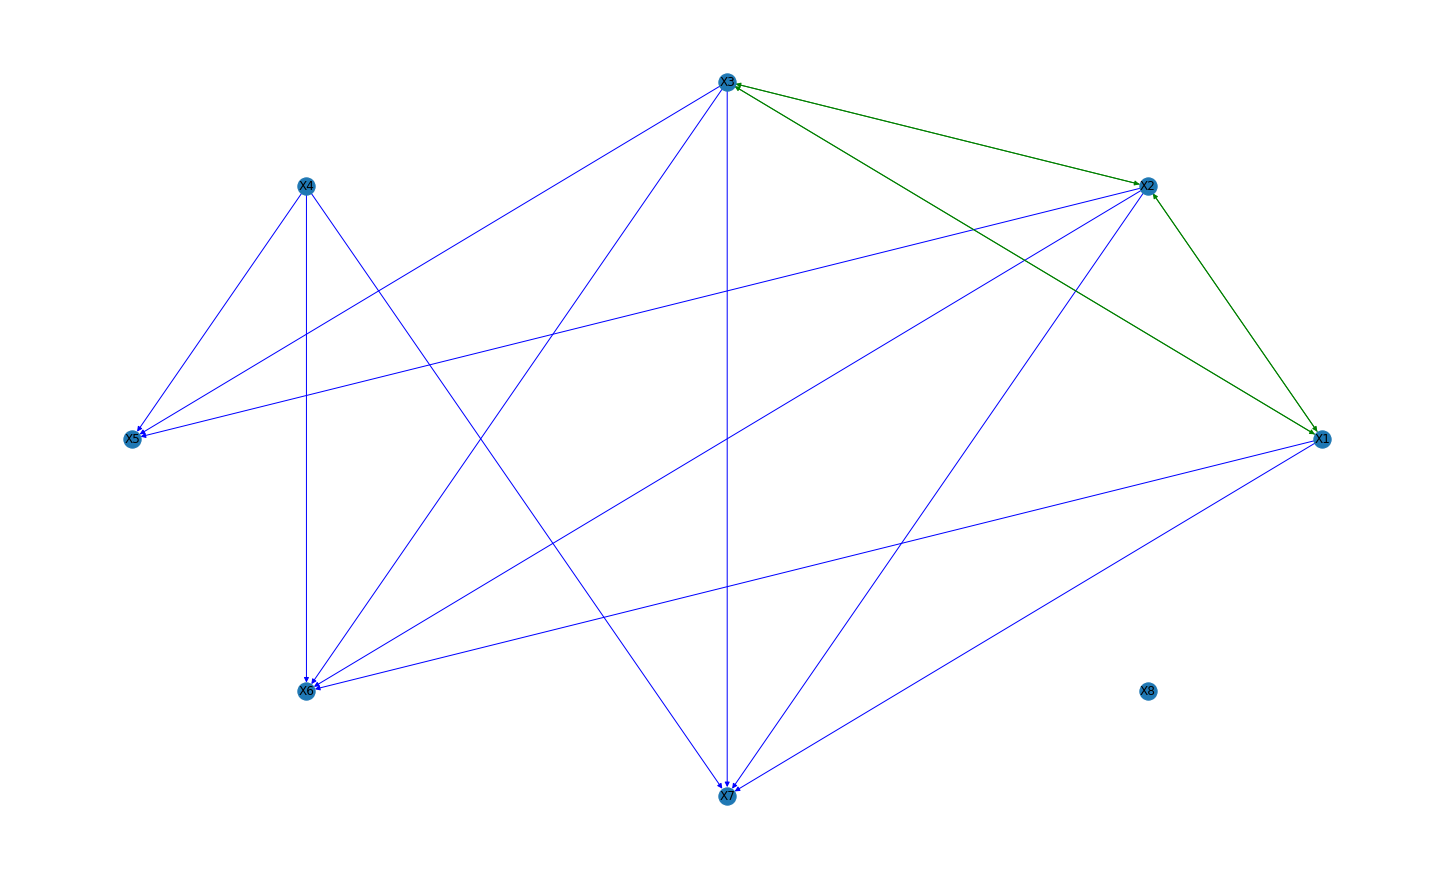

In [119]:
# Applying pc_time_series_1:

num_nodes_per_tier = dim+1
print(num_nodes_per_tier)
# cg, _ = pc_time_series_1(traj_dataset, num_nodes_per_tier, 0.05, fisherz)
_, cg = pc_time_series_1(traj_dataset, num_nodes_per_tier, 0.05, fisherz)

# visualization using pydot
cg.draw_pydot_graph()
# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)


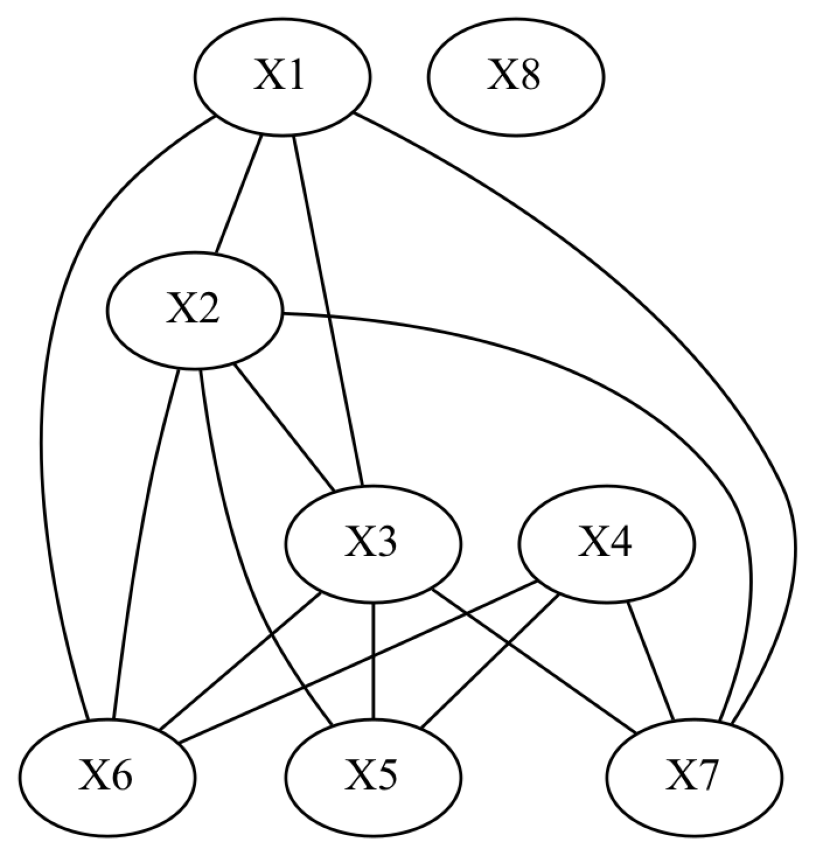

Green: undirected; Blue: directed; Red: bi-directed



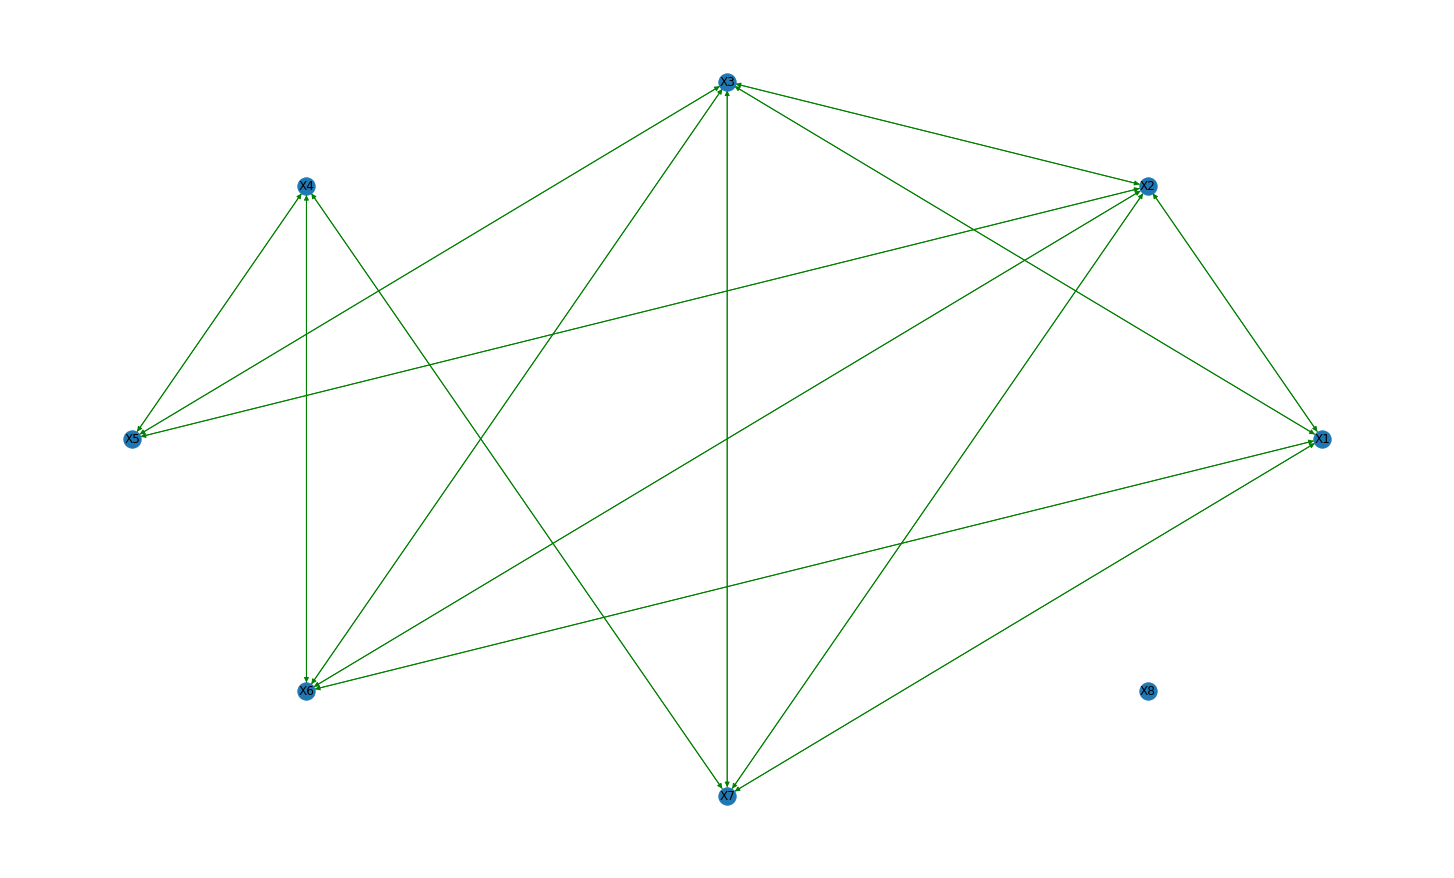

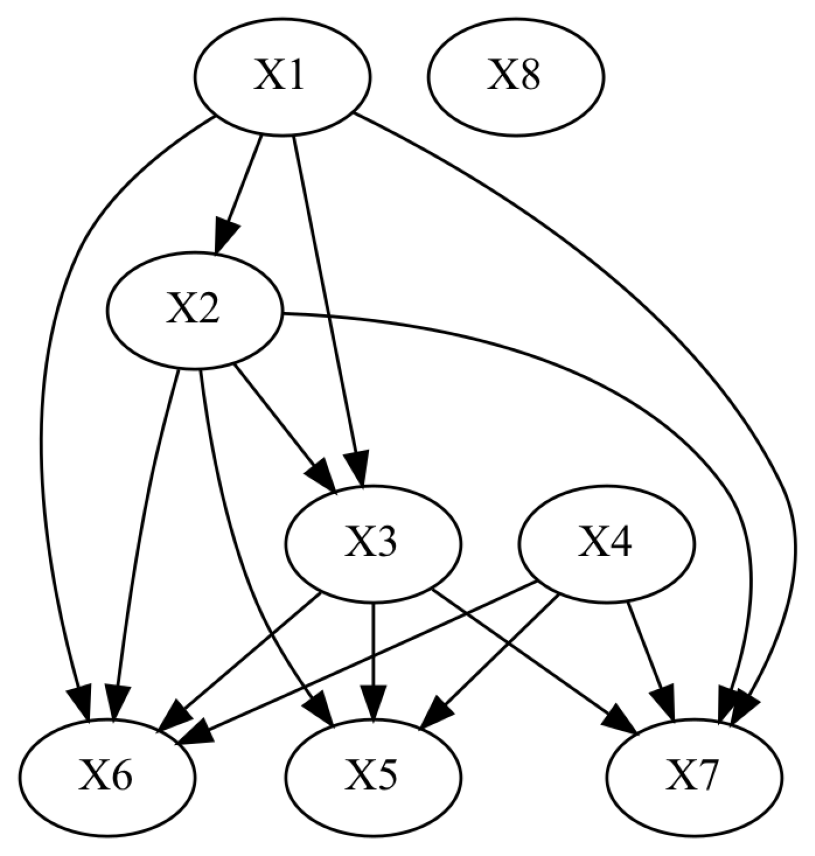

Green: undirected; Blue: directed; Red: bi-directed



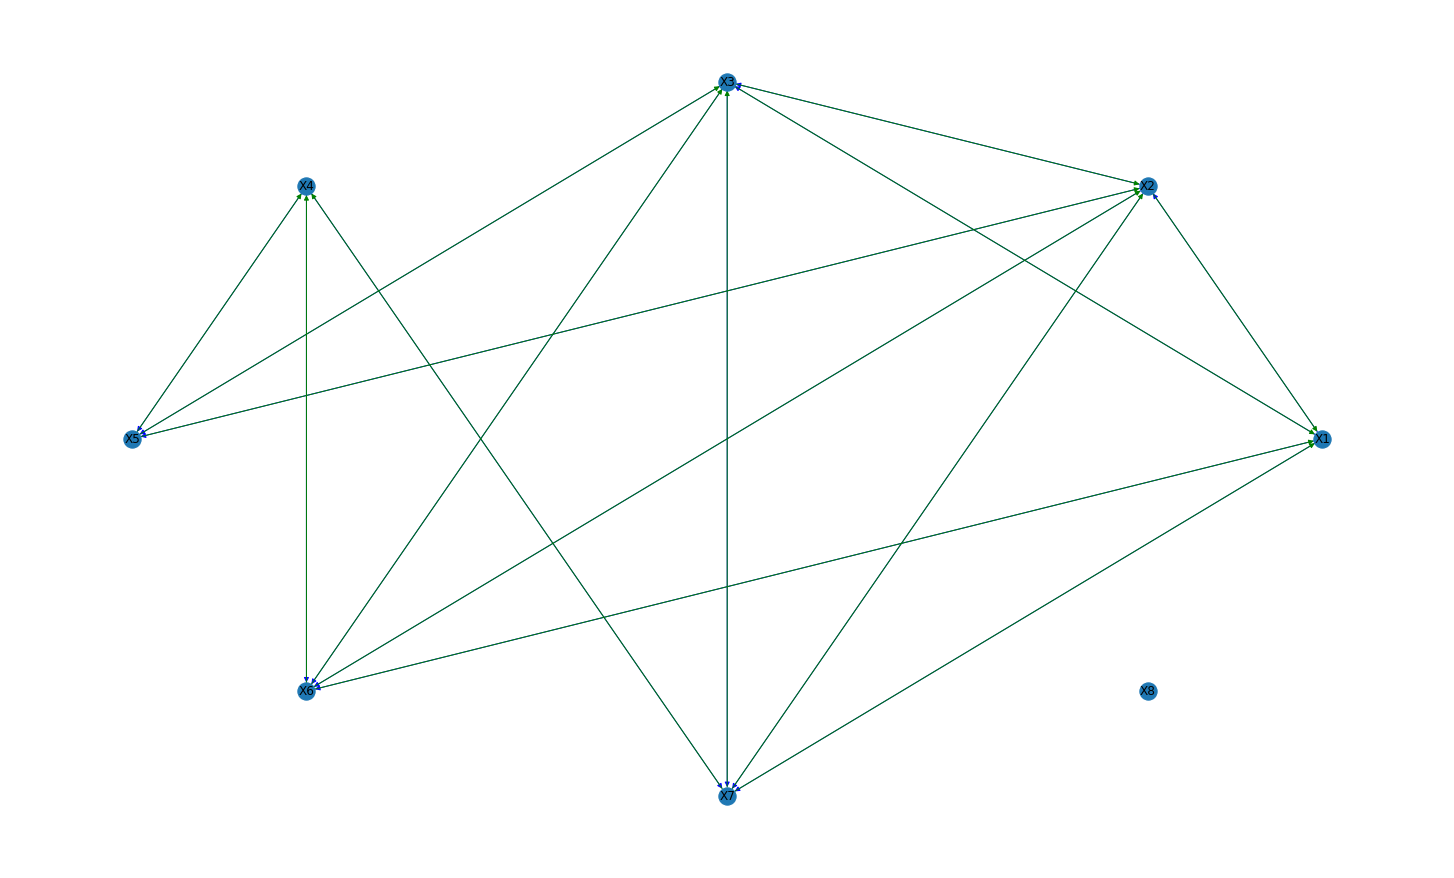

In [89]:
# Discover skeleton:

num_nodes_per_tier = dim+1
indep_test = CIT(traj_dataset, fisherz)
cg_skeleton = SkeletonDiscovery.skeleton_discovery(traj_dataset, 0.05, indep_test, True,
                                            background_knowledge=None, verbose=False,
                                            show_progress=False, node_names=None)
# visualization using pydot
cg_skeleton.draw_pydot_graph()
# # visualization using networkx
cg_skeleton.to_nx_graph()
cg_skeleton.draw_nx_graph(skel=False)


cg_nodes = cg_skeleton.G.get_nodes()
cg_prior = assign_prior_tiers(cg_skeleton, num_nodes_per_tier)

cg_1 = cg_skeleton
orient_by_background_knowledge(cg_1, cg_prior)

# visualization using pydot
cg_1.draw_pydot_graph()
# visualization using networkx
cg_1.to_nx_graph()
cg_1.draw_nx_graph(skel=False)



# # (3) Apply temporal constraints to E_{t, t+1}.
# cg_3 = deepcopy(cg_2)
# for (x, y) in itertools.product(np.arange(num_nodes_per_tier), repeat=2):
#     if cg_3.G.graph[x, y + num_nodes_per_tier] != 0:
#         cg_3.G.remove_edge(cg_3.G.get_edge(cg_3.G.nodes[x], cg_3.G.nodes[y + num_nodes_per_tier]))
#         cg_3.G.add_edge(Edge(cg_3.G.nodes[x], cg_3.G.nodes[y + num_nodes_per_tier], Endpoint.TAIL, Endpoint.ARROW))



#     data: np.ndarray,
#     alpha: float,
#     indep_test: str,
#     stable: bool,
#     uc_rule: int,
#     uc_priority: int,
#     background_knowledge,
#     verbose: bool = False,
#     show_progress: bool = True,



# Previous Results:

In [36]:
# traj_dataset_recorded_1 = traj_dataset

In [37]:
traj_dataset_recorded_1.shape

(200000, 8)

  0%|          | 0/8 [00:00<?, ?it/s]

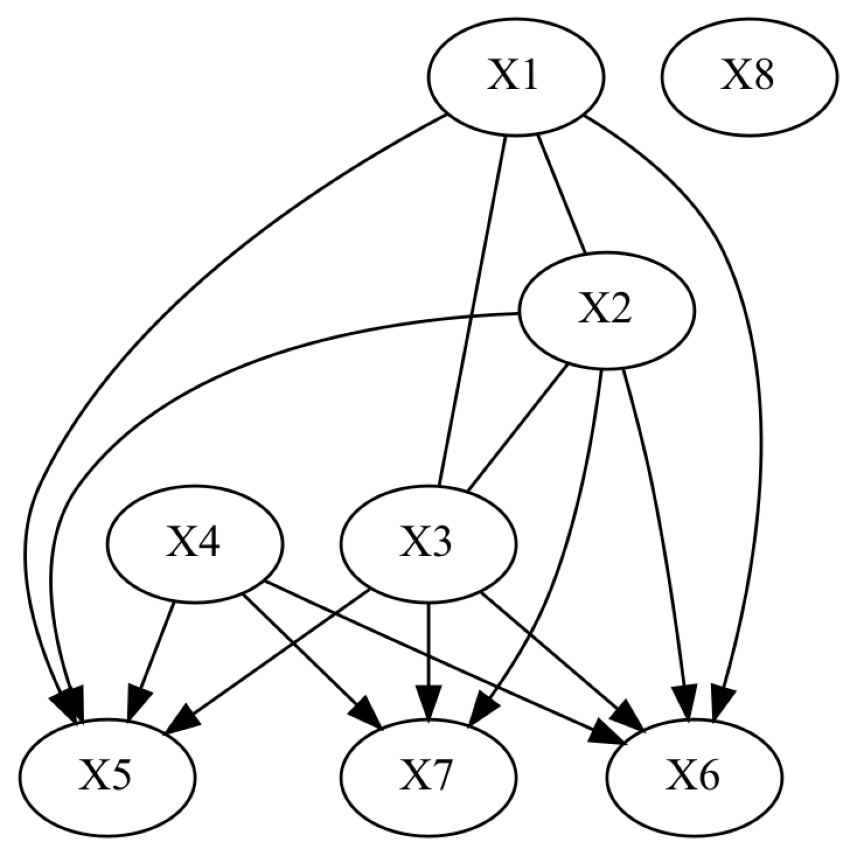

Green: undirected; Blue: directed; Red: bi-directed



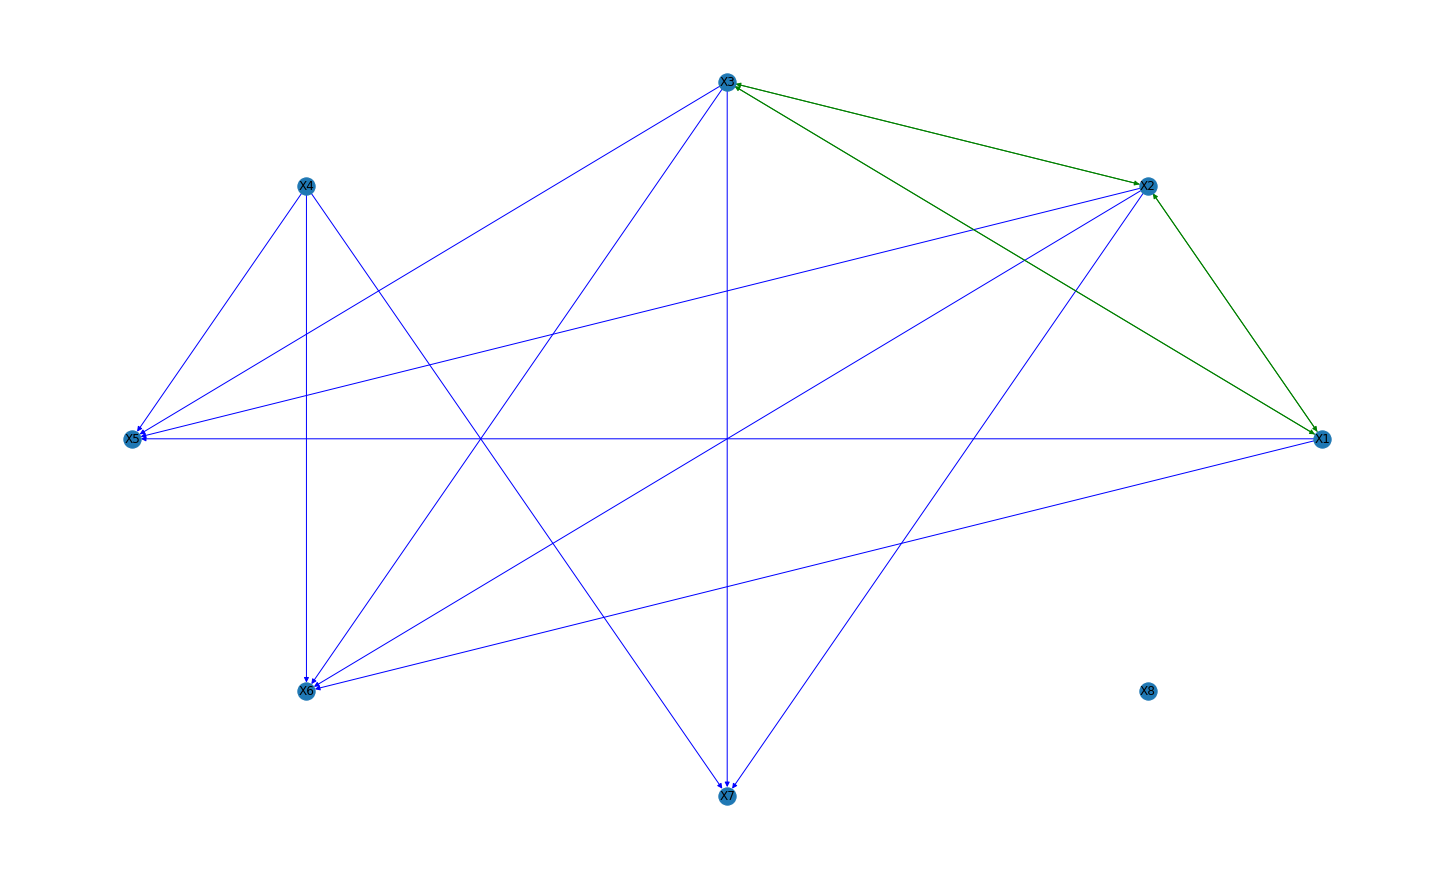

In [38]:
# traj_dataset_recorded_1 = traj_dataset

# # Run PC and obtain the estimated graph (CausalGraph object)
cg = pc(traj_dataset_recorded_1, 0.05, fisherz)  
# cg = pc(traj_dataset_recorded_1, 0.4, fisherz)

# visualization using pydot
cg.draw_pydot_graph()

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [ ]:
# To do:

# Plan A:
# (1) Skeleton search
# (2) Orient arrows

In [ ]:
# B = np.identity(2)
# B[:, 0] *= -1
# B